In [27]:
# import time
# import math
# import random
# import datetime

import torch
import torch.nn as nn
# import torch.nn.functional as F

# from scipy.stats import norm
# from sklearn.utils import shuffle

import pennylane as qml

# import numpy as np
import pandas as pd
# from matplotlib import pyplot as plt

### Functions

In [28]:
def train(x_train, y_train, 
          x_test, y_test, 
          model,
          epochs=50, batch_size=8, learning_rate=0.01):
    
    start_time = time.time()

    batches = len(y_train) // batch_size
    
    loss_function = torch.nn.MSELoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    data_loader_train = torch.utils.data.DataLoader(list(zip(x_train, y_train)), 
        batch_size=batch_size, shuffle=True, drop_last=True)
    
    data_loader_test = torch.utils.data.DataLoader(list(zip(x_test, y_test)), 
        batch_size=batch_size, shuffle=True, drop_last=True)
    
    best_model = model
    best_avg_train_loss = 0
    best_avg_test_loss = 0
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        
        epoch_train_loss = 0
        
        for xs, ys in data_loader_train:
            
            optimizer.zero_grad()
            
            loss_evaluated = loss_function(model(xs), ys)
            loss_evaluated.backward()
            
            optimizer.step()
            
            epoch_train_loss += loss_evaluated
            
        avg_train_loss = epoch_train_loss / batches
        train_losses.append(avg_train_loss)
        
        # Test
        
        epoch_test_loss = 0
        
        for xs, ys in data_loader_test:
            
            loss_evaluated = loss_function(model(xs), ys)
            epoch_test_loss += loss_evaluated
            
        avg_test_loss = epoch_test_loss / batches
        
        test_losses.append(avg_test_loss)
        
        
        if epoch == 0:
            best_avg_test_loss = avg_test_loss
            
        if avg_test_loss < best_avg_test_loss:
            best_avg_test_loss = avg_test_loss
            best_model = model
            
        if epoch % 2 == 0:
            print("Average train loss over epoch {}: {:.4f}".format(epoch, avg_train_loss))
            print("Average test loss over epoch {}: {:.4f}\n".format(epoch, avg_test_loss))
    
    print("Best train loss: %s" % (float(min(train_losses).detach())))
    print("Best test loss: %s" % (float(best_avg_test_loss.detach())))
    print("Train time: %s seconds" % (time.time() - start_time))
    
    return best_model, (torch.tensor(train_losses), torch.tensor(test_losses))

In [29]:
def plot_stock_prices(data_train, data_test, title='train'):
    
    data_train = data_train.sort_values('initial_stock_price')
    data_test = data_test.sort_values('initial_stock_price')
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})
    axs[0].scatter(data_train['initial_stock_price'], data_train['option_price'], s=4, c='b', 
                label='Monte-Carlo')
    axs[0].scatter(data_train['initial_stock_price'], data_train['predicted_option_price'], s=4, c='r',
                label='Model')
    axs[0].set_title('Train')
    axs[1].scatter(data_test['initial_stock_price'], data_test['option_price'], s=4, c='b', 
                label='Monte-Carlo')
    axs[1].scatter(data_test['initial_stock_price'], data_test['predicted_option_price'], s=4, c='r',
                label='Model')
    axs[1].set_title('Test')
    for ax in axs.flat:
        ax.set(xlabel='initial stock price', ylabel='option price')
        ax.label_outer()
    plt.savefig(title+'.png', facecolor='white', dpi=150)

In [30]:
def plot_loss(loss, title='train'):
    
    train_loss, test_loss = loss[0], loss[1]
    epochs = [i for i in range(len(train_loss))]
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})
    axs[0].plot(epochs, train_loss, c='b')
    axs[0].set_title('Train')
    axs[1].plot(epochs, test_loss, c='b')
    axs[1].set_title('Test')
    for ax in axs.flat:
        ax.set(xlabel='epoch', ylabel='loss')
        ax.label_outer()
    plt.savefig(title+'.png', facecolor='white', dpi=150)

### Data

In [31]:
data = pd.read_csv('water_potability.csv')

data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [32]:
data_train = data[:int(len(data)*0.7)].copy()
data_test = data[int(len(data)*0.7):].copy()

print(len(data), len(data_train), len(data_test))

3276 2293 983


### Model

In [33]:
n_qubits = 4
q_delta = 0.01
q_depth = 1

dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights):
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)
    for idx, element in enumerate(q_input_features):
        qml.RY(element, wires=idx)
    for k in range(q_depth):
        for i in range(0, n_qubits - 1, 2):
            qml.CNOT(wires=[i, i + 1])
        for i in range(1, n_qubits - 1, 2):
            qml.CNOT(wires=[i, i + 1])
        for idx, element in enumerate(q_weights):
            qml.RY(element, wires=idx)
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return exp_vals

In [34]:
class DressedQuantumNet(nn.Module):
    
    def __init__(self, n_features):
        super(DressedQuantumNet, self).__init__()
        self.pre_net = nn.Linear(n_features, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, n_features)

    def forward(self, input_features):
        pre_out = self.pre_net(input_features)
        q_in = pre_out
        q_out = torch.Tensor(0, n_qubits)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))
        return self.post_net(q_out)

In [35]:
class Model(nn.Module):
    def __init__(self, num_inputs=1, hidden=32):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(num_inputs, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = DressedQuantumNet(hidden)
        self.fc6 = nn.Linear(hidden, 1)
        
    def forward(self, x):
        self.num_inputs = x.shape[0]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return self.fc6(x)

### 4 input parameters

In [36]:
data.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [42]:
FEATURE_COLUMNS = ['ph', 'Hardness', 'Solids', 'Chloramines']
LABEL_COLUMN = ['Potability']

x_train = torch.tensor(data_train[FEATURE_COLUMNS].values).float()
y_train = torch.tensor(data_train[LABEL_COLUMN].values).float()

In [11]:
x_test = torch.tensor(data_test[FEATURE_COLUMNS].values).float()
y_test = torch.tensor(data_test[LABEL_COLUMN].values).float()

model = Model(num_inputs = x_train.shape[1])
trained_model, loss = train(x_train, y_train, x_test, y_test, model, epochs=5, 
                            learning_rate=0.0001)

Average train loss over epoch 0: 0.1290
Average test loss over epoch 0: 0.0058

Average train loss over epoch 2: 0.0003
Average test loss over epoch 2: 0.0001

Average train loss over epoch 4: 0.0001
Average test loss over epoch 4: 0.0000

Best train loss: 8.324293594341725e-05
Best test loss: 2.452312946843449e-05
Train time: 467.1857740879059 seconds


In [12]:
start_time = time.time()

y_pred = trained_model(x_train)
data_train['predicted_option_price'] = y_pred.detach().numpy()*max_option_price
data_train['initial_stock_price'] *= max_initial_stock_price
data_train['strike_price'] *= max_strike_price
data_train['option_price'] *= max_option_price

print("Time: %s seconds" % (time.time() - start_time))
data_train.head()

Time: 8.811582326889038 seconds


,initial_stock_price,volatility,risk_free_rate,strike_price,option_price,predicted_option_price
0,325.0,0.600000,0.026,31.111111,307.323368,307.056549
1,115.0,0.200000,0.038,52.222222,63.265262,60.831245
2,45.0,0.555556,0.038,94.444444,0.405437,3.151154
3,45.0,0.600000,0.026,31.111111,17.423759,31.564901
4,430.0,0.288889,0.050,157.777778,275.225067,275.969299


In [13]:
start_time = time.time()

y_pred = trained_model(x_test)
data_test['predicted_option_price'] = y_pred.detach().numpy()*max_option_price
data_test['initial_stock_price'] *= max_initial_stock_price
data_test['strike_price'] *= max_strike_price
data_test['option_price'] *= max_option_price

print("Time: %s seconds" % (time.time() - start_time))
data_train.head()

Time: 4.143638372421265 seconds


,initial_stock_price,volatility,risk_free_rate,strike_price,option_price,predicted_option_price
0,325.0,0.600000,0.026,31.111111,307.323368,307.056549
1,115.0,0.200000,0.038,52.222222,63.265262,60.831245
2,45.0,0.555556,0.038,94.444444,0.405437,3.151154
3,45.0,0.600000,0.026,31.111111,17.423759,31.564901
4,430.0,0.288889,0.050,157.777778,275.225067,275.969299


In [14]:
data_train.to_csv('hybrid_nn_dqc_train.csv', index=False)
data_test.to_csv('hybrid_nn_dqc_test.csv', index=False)

In [15]:
loss_data = pd.DataFrame()
loss_data['train_loss'] = loss[0]
loss_data['test_loss'] = loss[1]
loss_data.to_csv('hybrid_nn_dqc_loss.csv', index=False)
loss_data.head()

,train_loss,test_loss
0,0.128954,0.005775
1,0.002195,0.000219
2,0.000318,0.000078
3,0.000146,0.000043
4,0.000083,0.000025


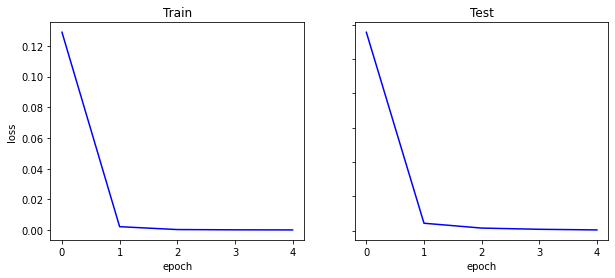

In [16]:
plot_loss(loss, 'hybrid_nn_dqc_loss')

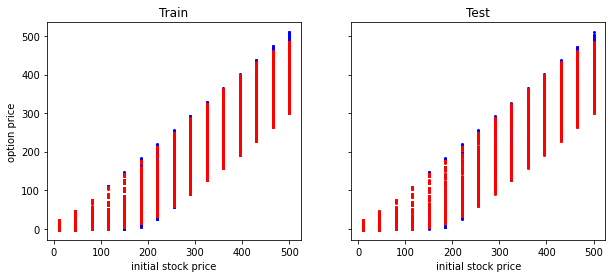

In [17]:
plot_stock_prices(data_train, data_test, title='hybrid_nn_dqc')